# Jenn Wong
jennwong@berkeley.edu

Data was gathered from Everlane Mode SQL database from running

select * from {database};

In [160]:
import pandas as pd
from copy import deepcopy
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [10]:
users_df = pd.read_csv('users.csv')
orders_df = pd.read_csv('orders.csv')
products_df = pd.read_csv('products.csv')

In [11]:
users_df.head()

,user_id,discovery_channel_category,discovery_channel,discovery_time,discovery_platform,location,gender
0,1957598,paid,other,2017-05-10 07:23:23,desktop,US,female
1,1771115,paid,affiliate,2017-02-15 16:33:02,mobile,US,female
2,1489936,direct,NaN,2016-09-13 16:07:53,desktop,US,female
3,2356025,paid,search,2017-10-12 17:13:53,desktop,US,female
4,1463297,organic search,NaN,2016-08-17 07:06:25,desktop,international,female


In [87]:
orders_df.head()

# this is a string and should be date-time for easier analysis
orders_df.completed_at = pd.to_datetime(orders_df.completed_at) 
orders_df.head()

,line_item_id,order_id,completed_at,user_id,quantity,price,style_id,order_channel,order_channel_category
0,14134747,2874138,2016-12-29 14:54:22,1444626,1,25.0,447,other,paid
1,17240079,3506498,2017-09-05 19:00:51,1125825,1,68.0,944,search,paid
2,20017564,4020991,2017-12-27 17:41:00,2521400,1,88.0,890,search,paid
3,19281489,3858476,2017-12-01 18:53:11,2222476,1,62.0,640,other,paid
4,15018380,3047663,2017-03-26 15:38:13,1854949,1,100.0,650,affiliate,paid


In [13]:
products_df.head()

,style_id,style,category,launch_date
0,592,The Premium Wool Flannel Pinstripe Track Pant,Bottoms,2016-09-19 00:00:00
1,572,The Luxe Drape Cropped Scoop-Neck Tee,Knit Tops,2016-07-26 00:00:00
2,645,The Cashmere Cardigan,Sweaters,2016-10-10 00:00:00
3,435,The Modern Flannel Shirt,Shirting,2016-02-25 00:00:00
4,874,The Pleated Midi Skirt,Bottoms,2017-08-24 00:00:00


In [16]:
products_df.info() # this shows me that I need to change the launch_date column into datetime


products_df.launch_date = pd.to_datetime(products_df.launch_date)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 4 columns):
style_id       455 non-null int64
style          455 non-null object
category       455 non-null object
launch_date    455 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 14.3+ KB


## Question 1: New Product Launches

1. How would you measure the strength of a new product?
2. Based on this methodology, how would you summarise the recent trends of Everlane launch performance? Please support your answer with data.
3. What are the areas of opportunity when it comes to new launches?


I will be defining the 'strength' of the new product as number of sales in the first two weeks of launch (because I know that Everlane releases new products every week and constitutes a large part of its revenue). This will allow me to see how it performs as a 'new product' as well as an 'old-er product' and identify seasonal trends (if any) in the week.

In order to answer this question, I need to get metadata on the products that were ordered. I will be joining the orders_df with the products_df on 'style_id' in order to get the data that I need.

Recent 'trends' would be looking at the product and its metadata to evaluate if certain types of items are gaining popularity or something, or maybe something in the orders (discovery channel), or maybe it's the price bin 

In [54]:
detailed_orders = pd.merge(orders_df, products_df, how = 'left', on  = 'style_id')

I could have done this in SQL too with the following query:

select * 
from recruiting.orders o
left join recruiting.products p on p.style_id = o.style_id;

In [121]:
time_period = 14 # this is the number of days after launch that I care about

detailed_orders['time_since_launch'] = (detailed_orders.completed_at - detailed_orders.launch_date)


# i only care about the days since launch and not such a high resolution
def get_days(date_time_object):
    """
    this function takes a datetime object and returns the days
    """
    return date_time_object.days

detailed_orders['days_since_launch'] = detailed_orders.time_since_launch.apply(get_days)

# I am creating a mask for orders made within the time period i'm interested in.
# sanity check, I know that all orders are at least 0 days since launch. there are some errors in the data though... 
recent_mask = (detailed_orders.days_since_launch <= time_period) & (detailed_orders.days_since_launch >0)

new_orders = detailed_orders[recent_mask]

print(f'I started with {len(detailed_orders)} number of orders. I now have {len(new_orders)} rows of recent orders')
# len(new_orders

new_orders.head()

I started with 43548 number of orders. I now have 4327 rows of recent orders


,line_item_id,order_id,completed_at,user_id,quantity,price,style_id,order_channel,order_channel_category,style,category,launch_date,time_since_launch,days_since_launch
9,12912030,2563686,2016-10-10 00:34:32,1333122,1,100.0,642,affiliate,paid,The Cashmere Crew,Sweaters,2016-10-03,7 days 00:34:32,7
29,14599945,2973712,2017-02-15 06:11:10,1769008,1,68.0,715,affiliate,paid,The Wide Leg Crop Pant,Bottoms,2017-02-14,1 days 06:11:10,1
37,14687198,2989227,2017-02-24 11:59:12,1732638,1,68.0,715,other,paid,The Wide Leg Crop Pant,Bottoms,2017-02-14,10 days 11:59:12,10
44,16116627,3290378,2017-06-18 05:40:10,656605,1,25.0,934,search,paid,Human Pride Unisex Tank in Double Print,Knit Tops,2017-06-05,13 days 05:40:10,13
48,18280552,3679979,2017-10-21 17:49:11,2380929,1,155.0,933,search,paid,The Waffle Knit Cashmere Square Crew,Sweaters,2017-10-12,9 days 17:49:11,9


In [119]:
# so now I need to find the count of sales for each day over two weeks after launch for each product
sale_count = new_orders.groupby(['style_id', 'days_since_launch']).size().reset_index()
sale_count.rename(columns = {
    0: 'daily_order_count'
}, inplace = True)

total_sales = sale_count.groupby('style_id').sum()['daily_order_count']
total_sales = deepcopy(total_sales.sort_values(ascending = False)).reset_index()
total_sales.rename(columns = {
    'daily_order_count': 'total_order_count'
}, inplace = True)
total_sales.head()
# a way to visualize this would be to look at the top n performers and their sales and compare to bottom n


# I will take the top n products in terms of total number of sales in the time period and 


,style_id,total_order_count
0,908,152
1,887,80
2,909,73
3,888,61
4,642,57


In [120]:
total_sales = pd.merge(pd.DataFrame(total_sales), products_df, how = 'left', on = 'style_id')
total_sales.head(25)

,style_id,total_order_count,style,category,launch_date
0,908,152,The High-Rise Skinny Jean (Ankle),Denim,2017-09-07
1,887,80,The Square Mockneck Tee,Knit Tops,2017-08-28
2,909,73,The Mid-Rise Skinny Jean (Ankle),Denim,2017-09-07
3,888,61,The Square Tee,Knit Tops,2017-08-28
4,642,57,The Cashmere Crew,Sweaters,2016-10-03
5,862,55,The Cotton Box-Cut Tee Dress,Knit Dresses,2017-06-23
6,923,54,The Long Puffer Jacket,Outerwear,2017-11-06
7,954,53,The Oversized Blazer,Outerwear,2017-10-31
8,869,46,The Bridge Sandal,Footwear,2017-06-05
9,907,44,The Italian GoWeave Easy Pant,Bottoms,2017-09-18


I think it would be interesting to see what is the most popular category over each month/time period

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

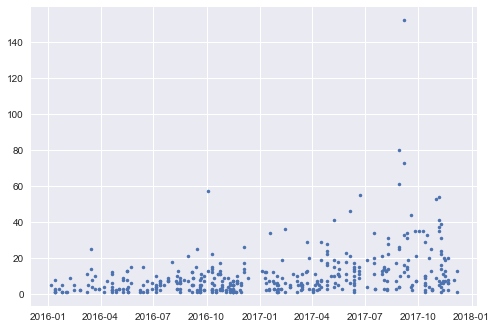

In [165]:
plt.plot(total_sales.launch_date, total_sales.total_order_count, '.');

# i think it would be nice to plot a regression line to see the slope if it's trending upwards

{'Knit Tops', 'Denim', 'Sweaters', 'Outerwear', 'Footwear', 'Knit Dresses'}


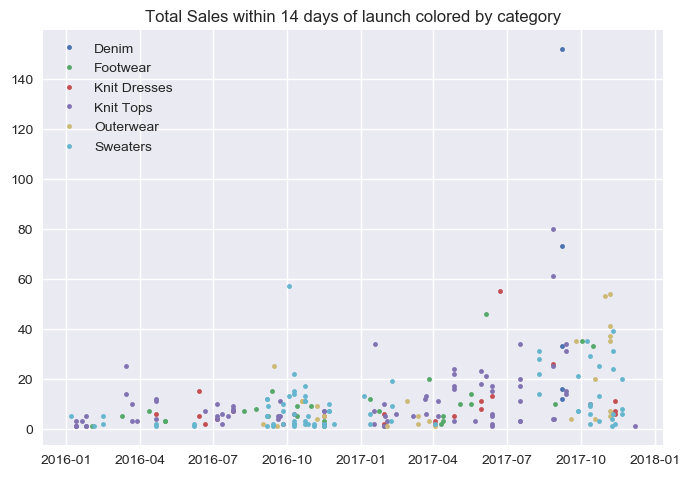

In [181]:
plt.figure(dpi = 100)

# im going to define popular categories as categories that dominant to upper sales of total_sales
top_partition = len(total_sales)//45 # done interatively to get smaller set of colors to graph

popular_categories = set(total_sales.category[:top_partition])
print(popular_categories)

for name, grp in (total_sales.groupby(['category'])):
    if name in popular_categories:
        plt.plot(grp['launch_date'], grp['total_order_count'], '.', label=name)

plt.title(f'Total Sales within {time_period} days of launch colored by category')    
plt.legend();

Harmeet suggested that I consider doing A/B/C product splits to understand what does well

If I had more time, I would try to model this information by figuring out which features will make a product a 'success' as defined by having higher than average total sales. i think it would also be interesting to look at the projections for a product and compare it to how well it actually did

#### Additionally, I know that new users drive revenue for Everlane as well. 
Therefore I think it's important to see how new_products fair for this segment of the market, and possibly compare it to not-new users as well. If there is a strong sales trend in non-new users, that could be an indicator of the 'strength' of the new product!